# Scanpy: Dimensionality reduction 

## Data preparation
***

First, let's load all necessary libraries and the QC-filtered dataset from the previous step.


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()



sc

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.16.4 scipy==1.3.0 pandas==0.25.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1


<module 'scanpy' from '/usr/local/lib/python3.7/site-packages/scanpy/__init__.py'>

In [2]:
sc.settings.set_figure_params(dpi=80)

In [4]:
pwd

'/Users/rui.benfeitas/GitHub/scRNAseq_27012020/workshop-scRNAseq/labs/compiled/scanpy'

In [5]:
adata = sc.read_h5ad('data/scanpy_qc_filtered_3pbmc.h5ad')


In [6]:
adata

AnnData object with n_obs × n_vars = 2527 × 16766 
    obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'lib_prep_colors'

 Before variable gene selection we need to normalize and logaritmize the data. As in the QC-lab, first store the raw data in the `raw`  slot.


In [7]:
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

adata

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 2527 × 16766 
    obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'lib_prep_colors', 'log1p'

Next, we first need to define which features/genes are important in our dataset to distinguish cell types. For this purpose, we need to find genes that are highly variable across cells, which in turn will also provide a good separation of the cell clusters.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 2472


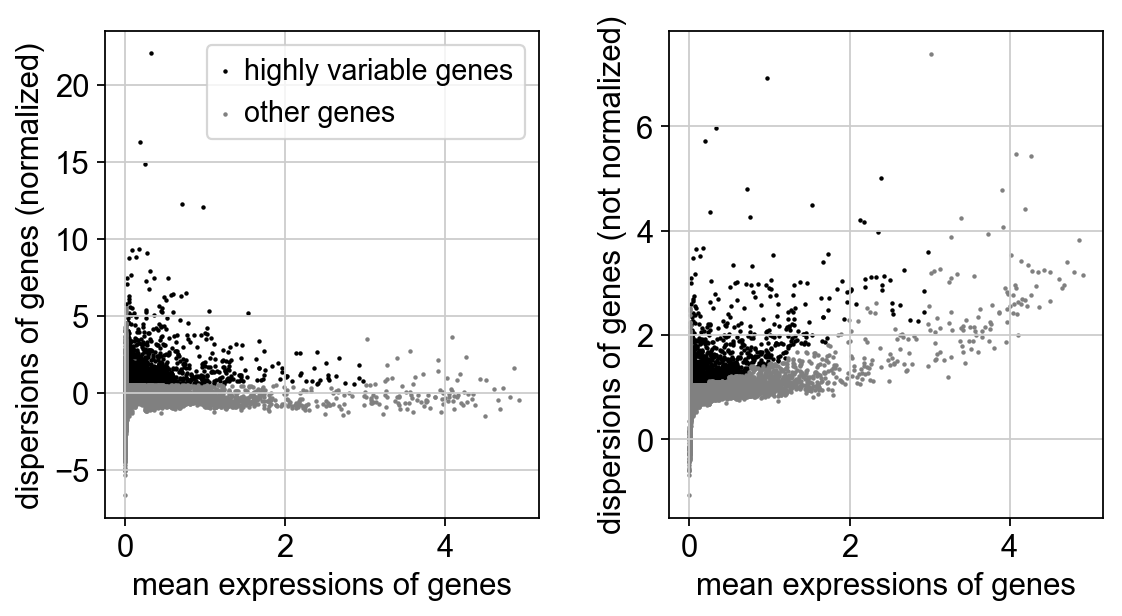

In [8]:
# compute variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(adata.var.highly_variable))

#plot variable genes
sc.pl.highly_variable_genes(adata)

# subset for variable genes in the dataset
adata = adata[:, adata.var['highly_variable']]


### Z-score transformation

Now that the data is prepared, we now proceed with PCA. Since each gene has a different expression level, it means that genes with higher expression values will naturally have higher variation that will be captured by PCA. This means that we need to somehow give each gene a similar weight when performing PCA (see below). The common practice is to center and scale each gene before performing PCA. This exact scaling is called Z-score normalization it is very useful for PCA, clustering and plotting heatmaps. Additionally, we can use regression to remove any unwanted sources of variation from the dataset, such as `cell cycle`, `sequencing depth`, `percent mitocondria`. This is achieved by doing a generalized linear regression using these parameters as covariates in the model. Then the residuals of the model are taken as the "regressed data". Although perhaps not in the best way, batch effect regression can also be done here.


In [10]:
# adata = adata.copy()     #run this line if you get the "AttributeError: swapaxes not found" 

# regress out unwanted variables
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

# scale data, clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


## PCA
***

Performing PCA has many useful applications and interpretations, which much depends on the data used. In the case of life sciences, we want to segregate samples based on gene expression patterns in the data.


In [11]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


We then plot the first principal components.


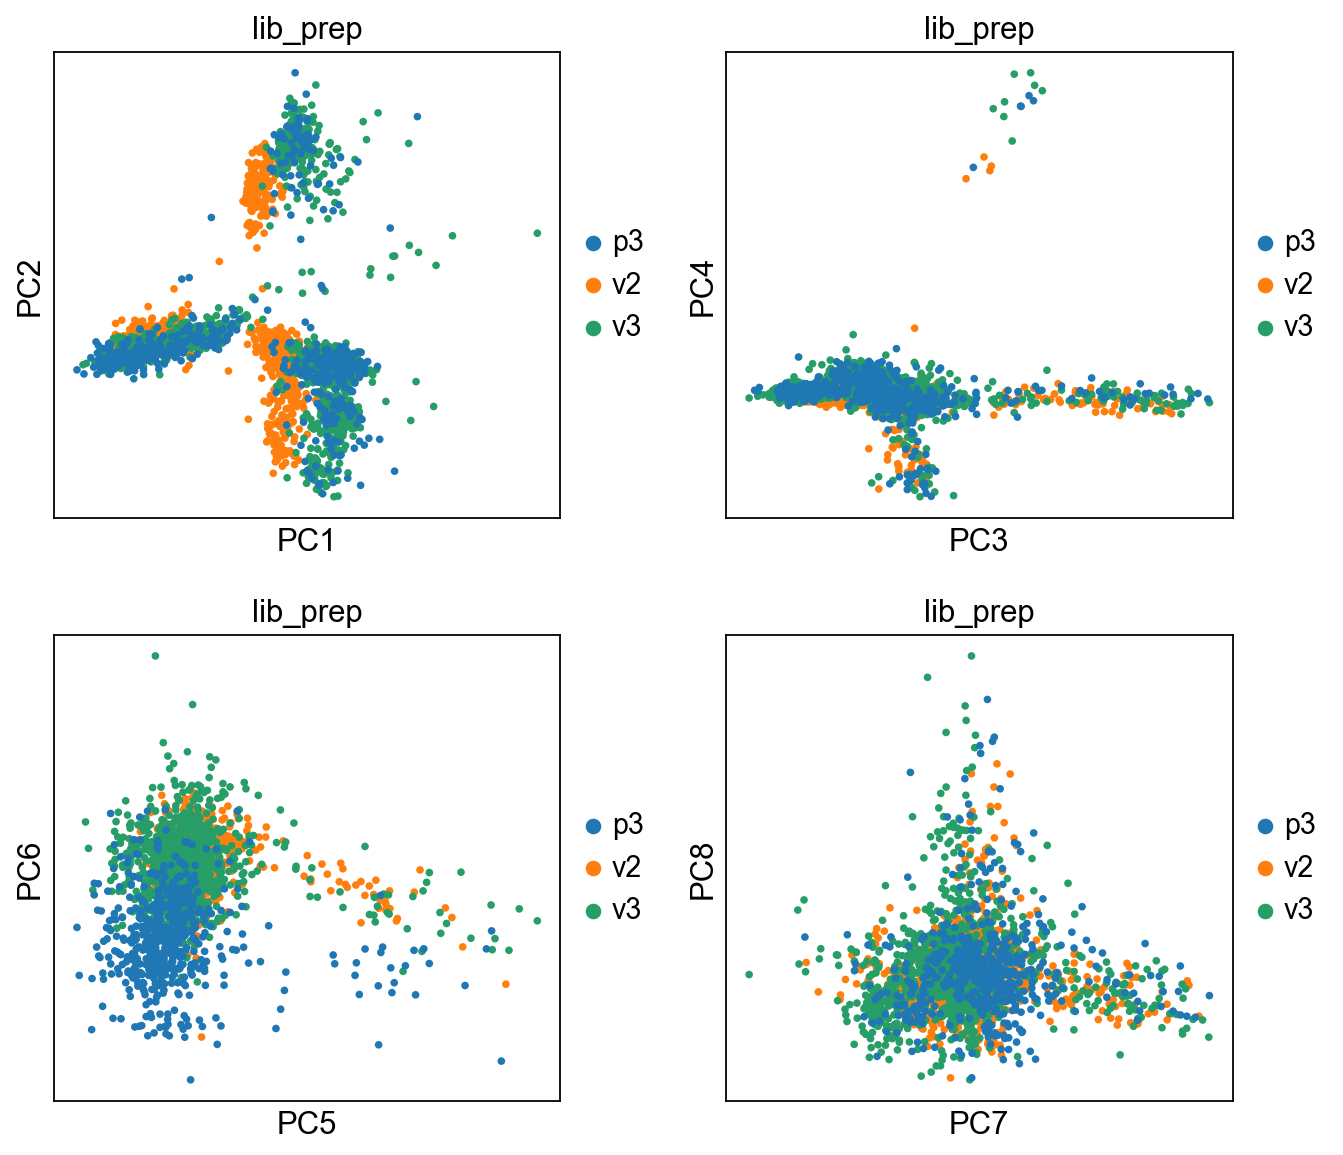

In [12]:
# plot more PCS

sc.pl.pca(adata, color='lib_prep', components = ['1,2','3,4','5,6','7,8'], ncols=2)


To identify genes that contribute most to each PC, one can retreive the loading matrix information. 


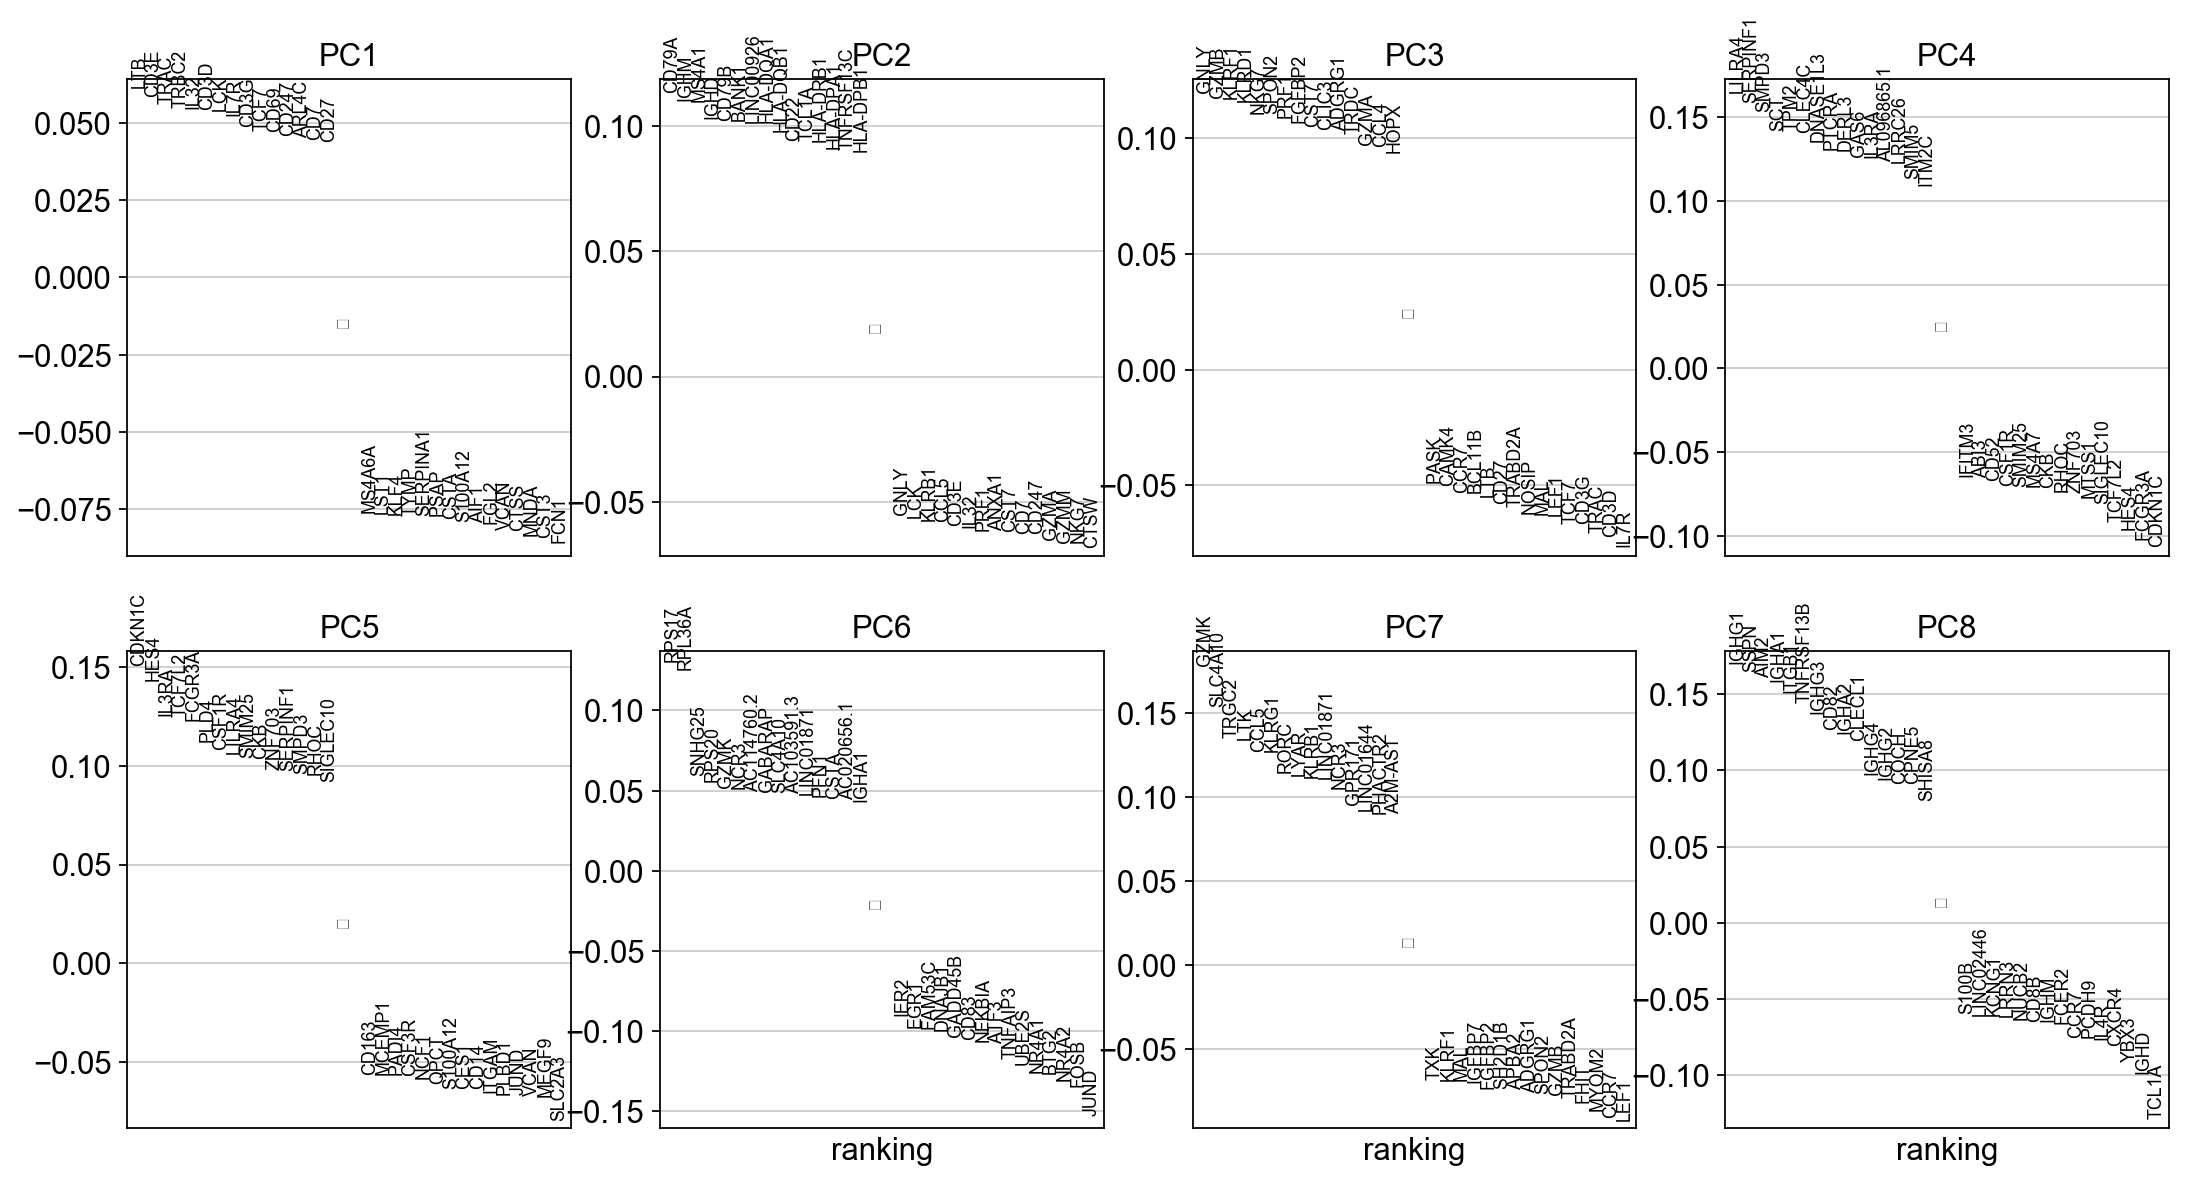

In [13]:
#Plot loadings
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6,7,8])

# OBS! only plots the positive axes genes from each PC!!


The function to plot loading genes only plots genes on the positive axes. Instead plot as a heatmaps, with genes on both postive and negative side, one per pc, and plot their expression amongst cells ordered by their position along the pc.


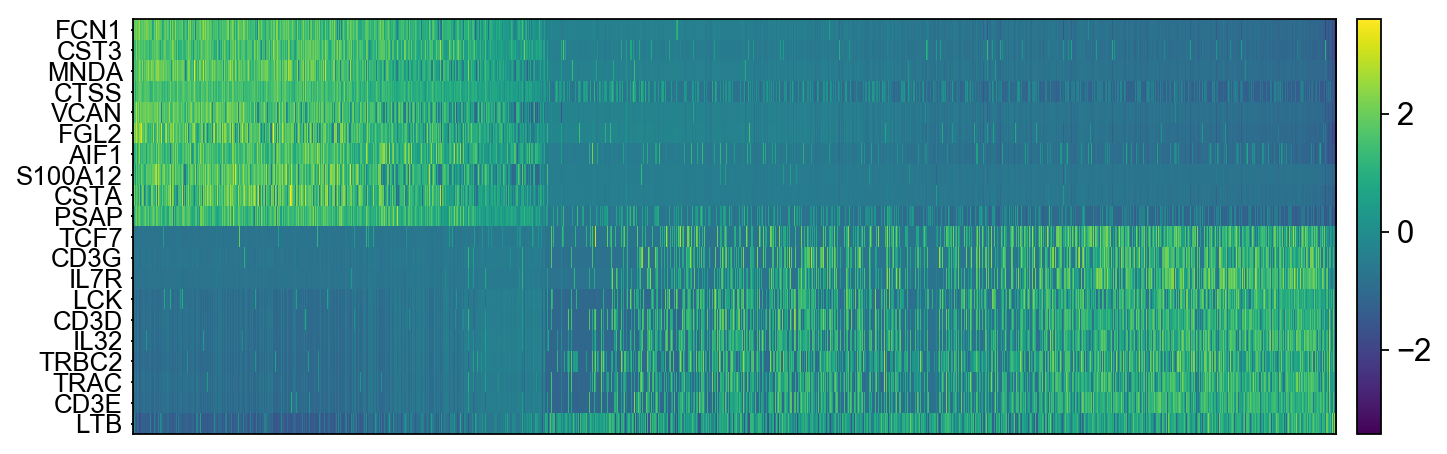

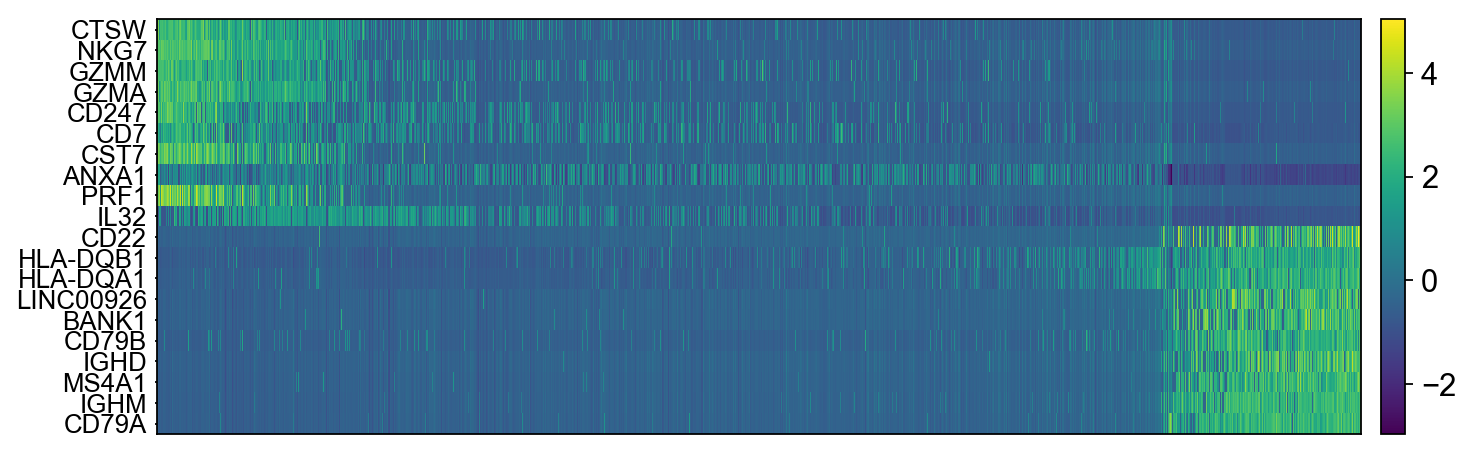

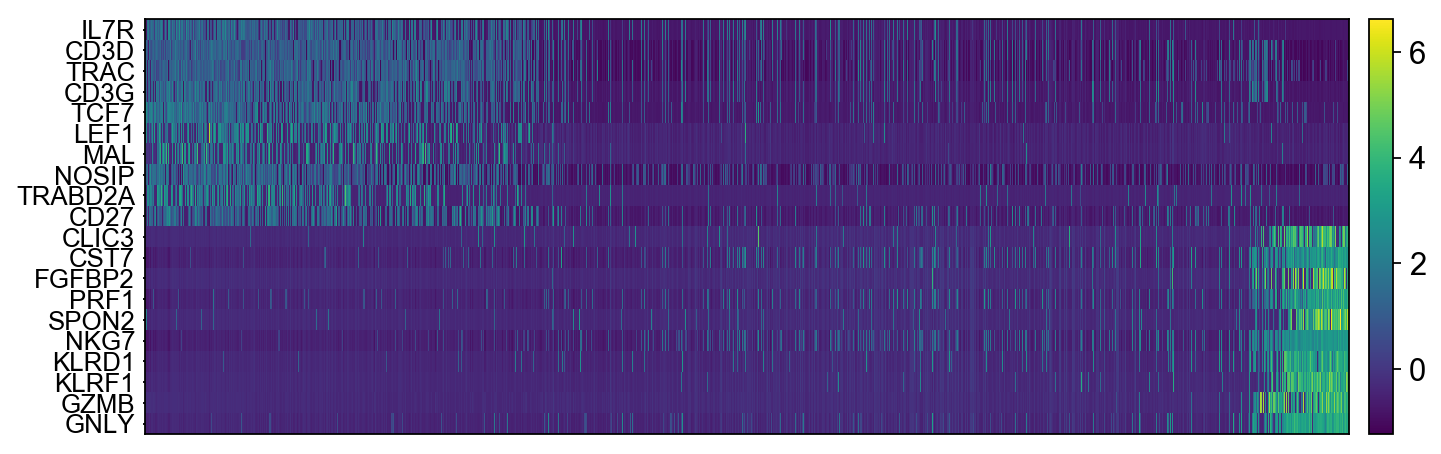

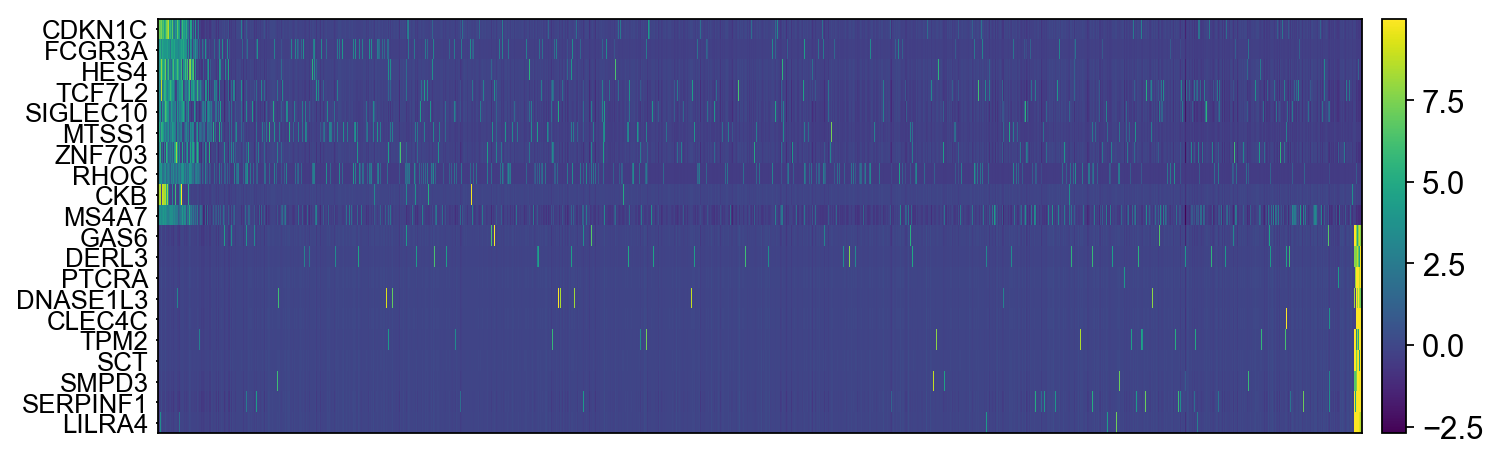

In [14]:
# adata.obsm["X_pca"] is the embeddings
# adata.uns["pca"] is pc variance
# adata.varm['PCs'] is the loadings

genes = adata.var['gene_ids']

for pc in [1,2,3,4]:
    g = adata.varm['PCs'][:,pc-1]
    o = np.argsort(g)
    sel = np.concatenate((o[:10],o[-10:])).tolist()
    emb = adata.obsm['X_pca'][:,pc-1]
    # order by position on that pc
    tempdata = adata[np.argsort(emb),]
    sc.pl.heatmap(tempdata, var_names = genes[sel].index.tolist(), swap_axes = True, use_raw=False)


We can also plot the amount of variance explained by each PC.


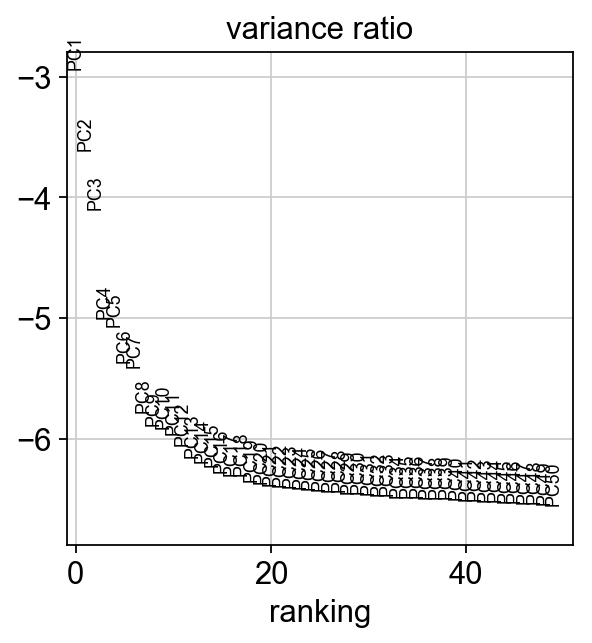

In [15]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

Based on this plot, we can see that the top 8 PCs retain a lot of information, while other PCs contain pregressivelly less. However, it is still advisable to use more PCs since they might contain informaktion about rare cell types (such as platelets and DCs in this dataset)


## tSNE
***
We can now run [BH-tSNE](https://arxiv.org/abs/1301.3342).


In [20]:
sc.tl.tsne(adata, n_pcs = 30)


computing tSNE
    using 'X_pca' with n_pcs = 30
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:12)


We can now plot the tSNE colored per dataset. We can clearly see the effect of batches present in the dataset.


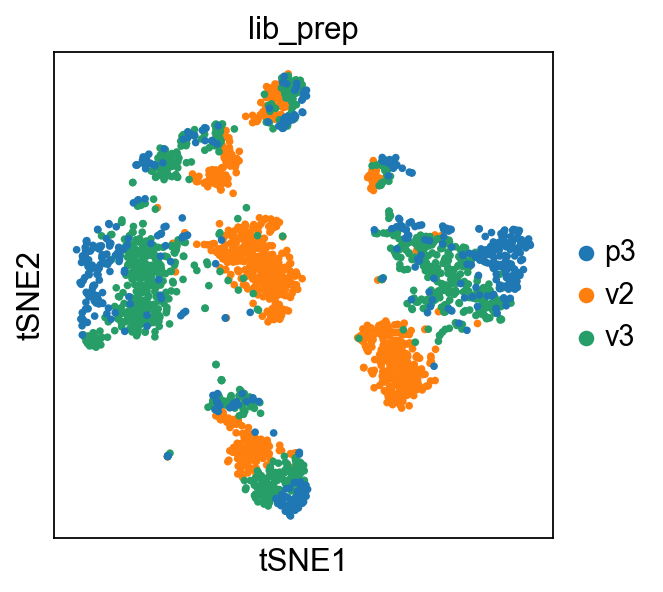

In [21]:
sc.pl.tsne(adata, color='lib_prep')

## UMAP
***

We can now run [UMAP](https://arxiv.org/abs/1802.03426) for cell embeddings.

### Calculate neighborhood graph

The UMAP implementation in SCANPY uses a neighborhood graph as the distance matrix, so we need to first calculate the graph. 


In [22]:
sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 20)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


Now we can run UMAP.


In [23]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


Another usefullness of UMAP is that it is not limitted by the number of dimensions the data cen be reduced into (unlike tSNE). We can simply reduce the dimentions altering the `n.components` parameter.


In [24]:
#run with 10 components, save to a new object so that the umap with 2D is not overwritten.
umap10 = sc.tl.umap(adata, n_components=10, copy=True)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


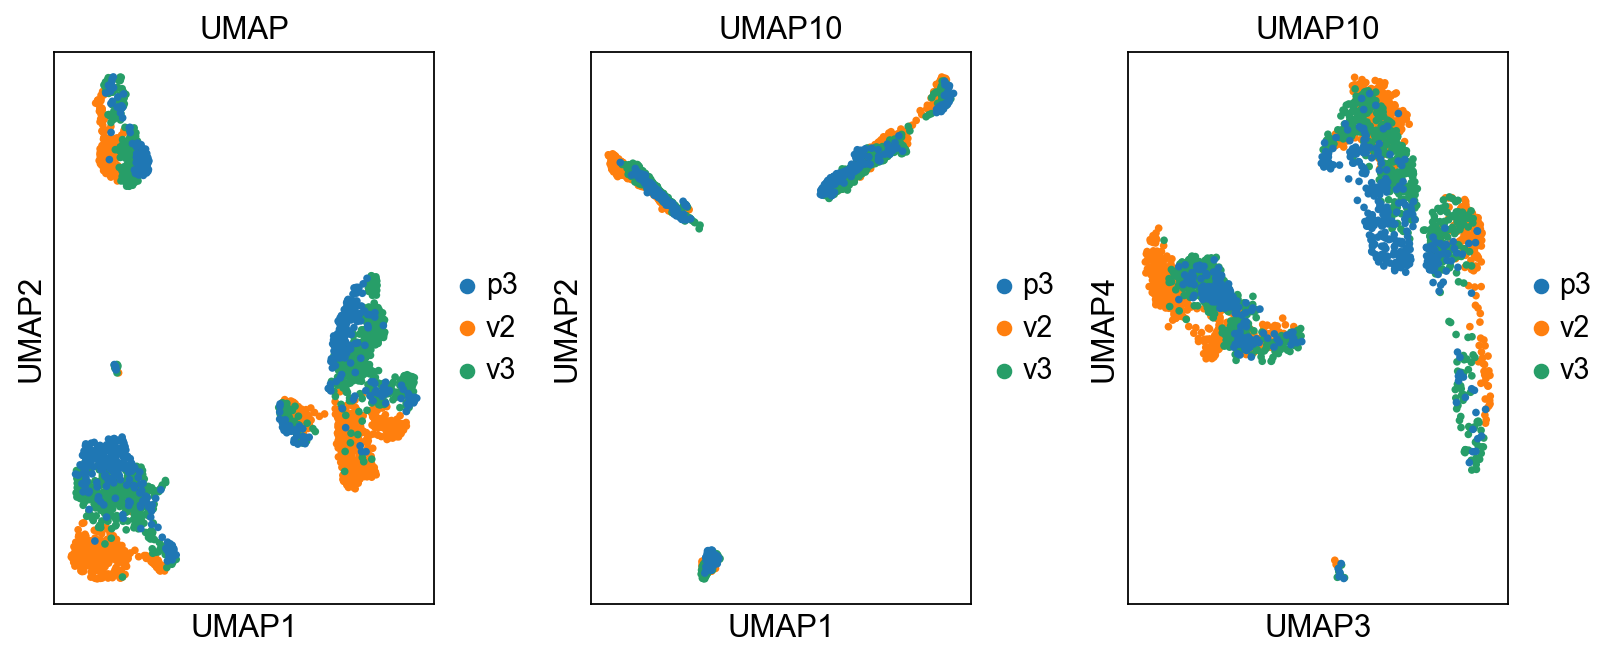

In [25]:

fig, axs = plt.subplots(1, 3, figsize=(10,4),constrained_layout=True)

sc.pl.umap(adata, color='lib_prep',  title="UMAP", show=False, ax=axs[0])
sc.pl.umap(umap10, color='lib_prep', title="UMAP10", show=False, ax=axs[1], components=[1,2])
sc.pl.umap(umap10, color='lib_prep', title="UMAP10", show=False, ax=axs[2], components=[3,4])


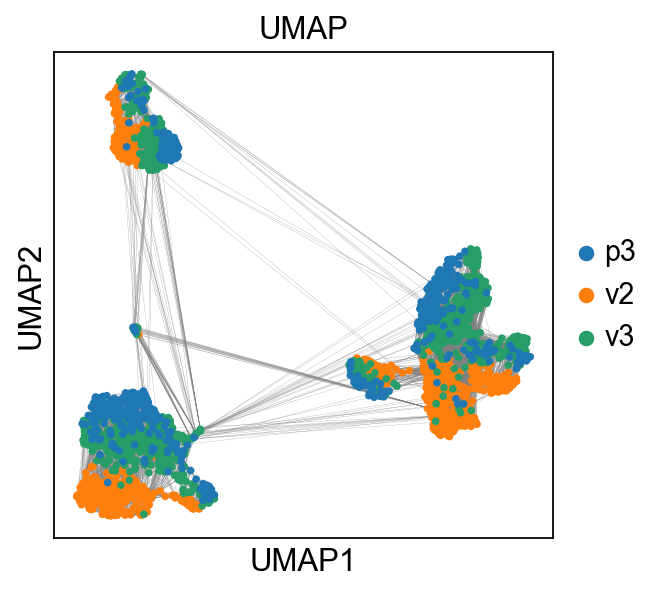

In [26]:
# we can also plot the umap with neighbor edges
sc.pl.umap(adata, color='lib_prep', title="UMAP", edges=True)

## Ploting genes of interest
***

Let's plot some marker genes for different celltypes onto the embedding. Some genes are:

Markers	| Cell Type
--- | ---
CD3E	| T cells
CD3E CD4	| CD4+ T cells
CD3E CD8A	| CD8+ T cells
GNLY, NKG7	| NK cells
MS4A1	| B cells
CD14, LYZ, CST3, MS4A7	| CD14+ Monocytes
FCGR3A, LYZ, CST3, MS4A7	| FCGR3A+  Monocytes
FCER1A, CST3 | DCs


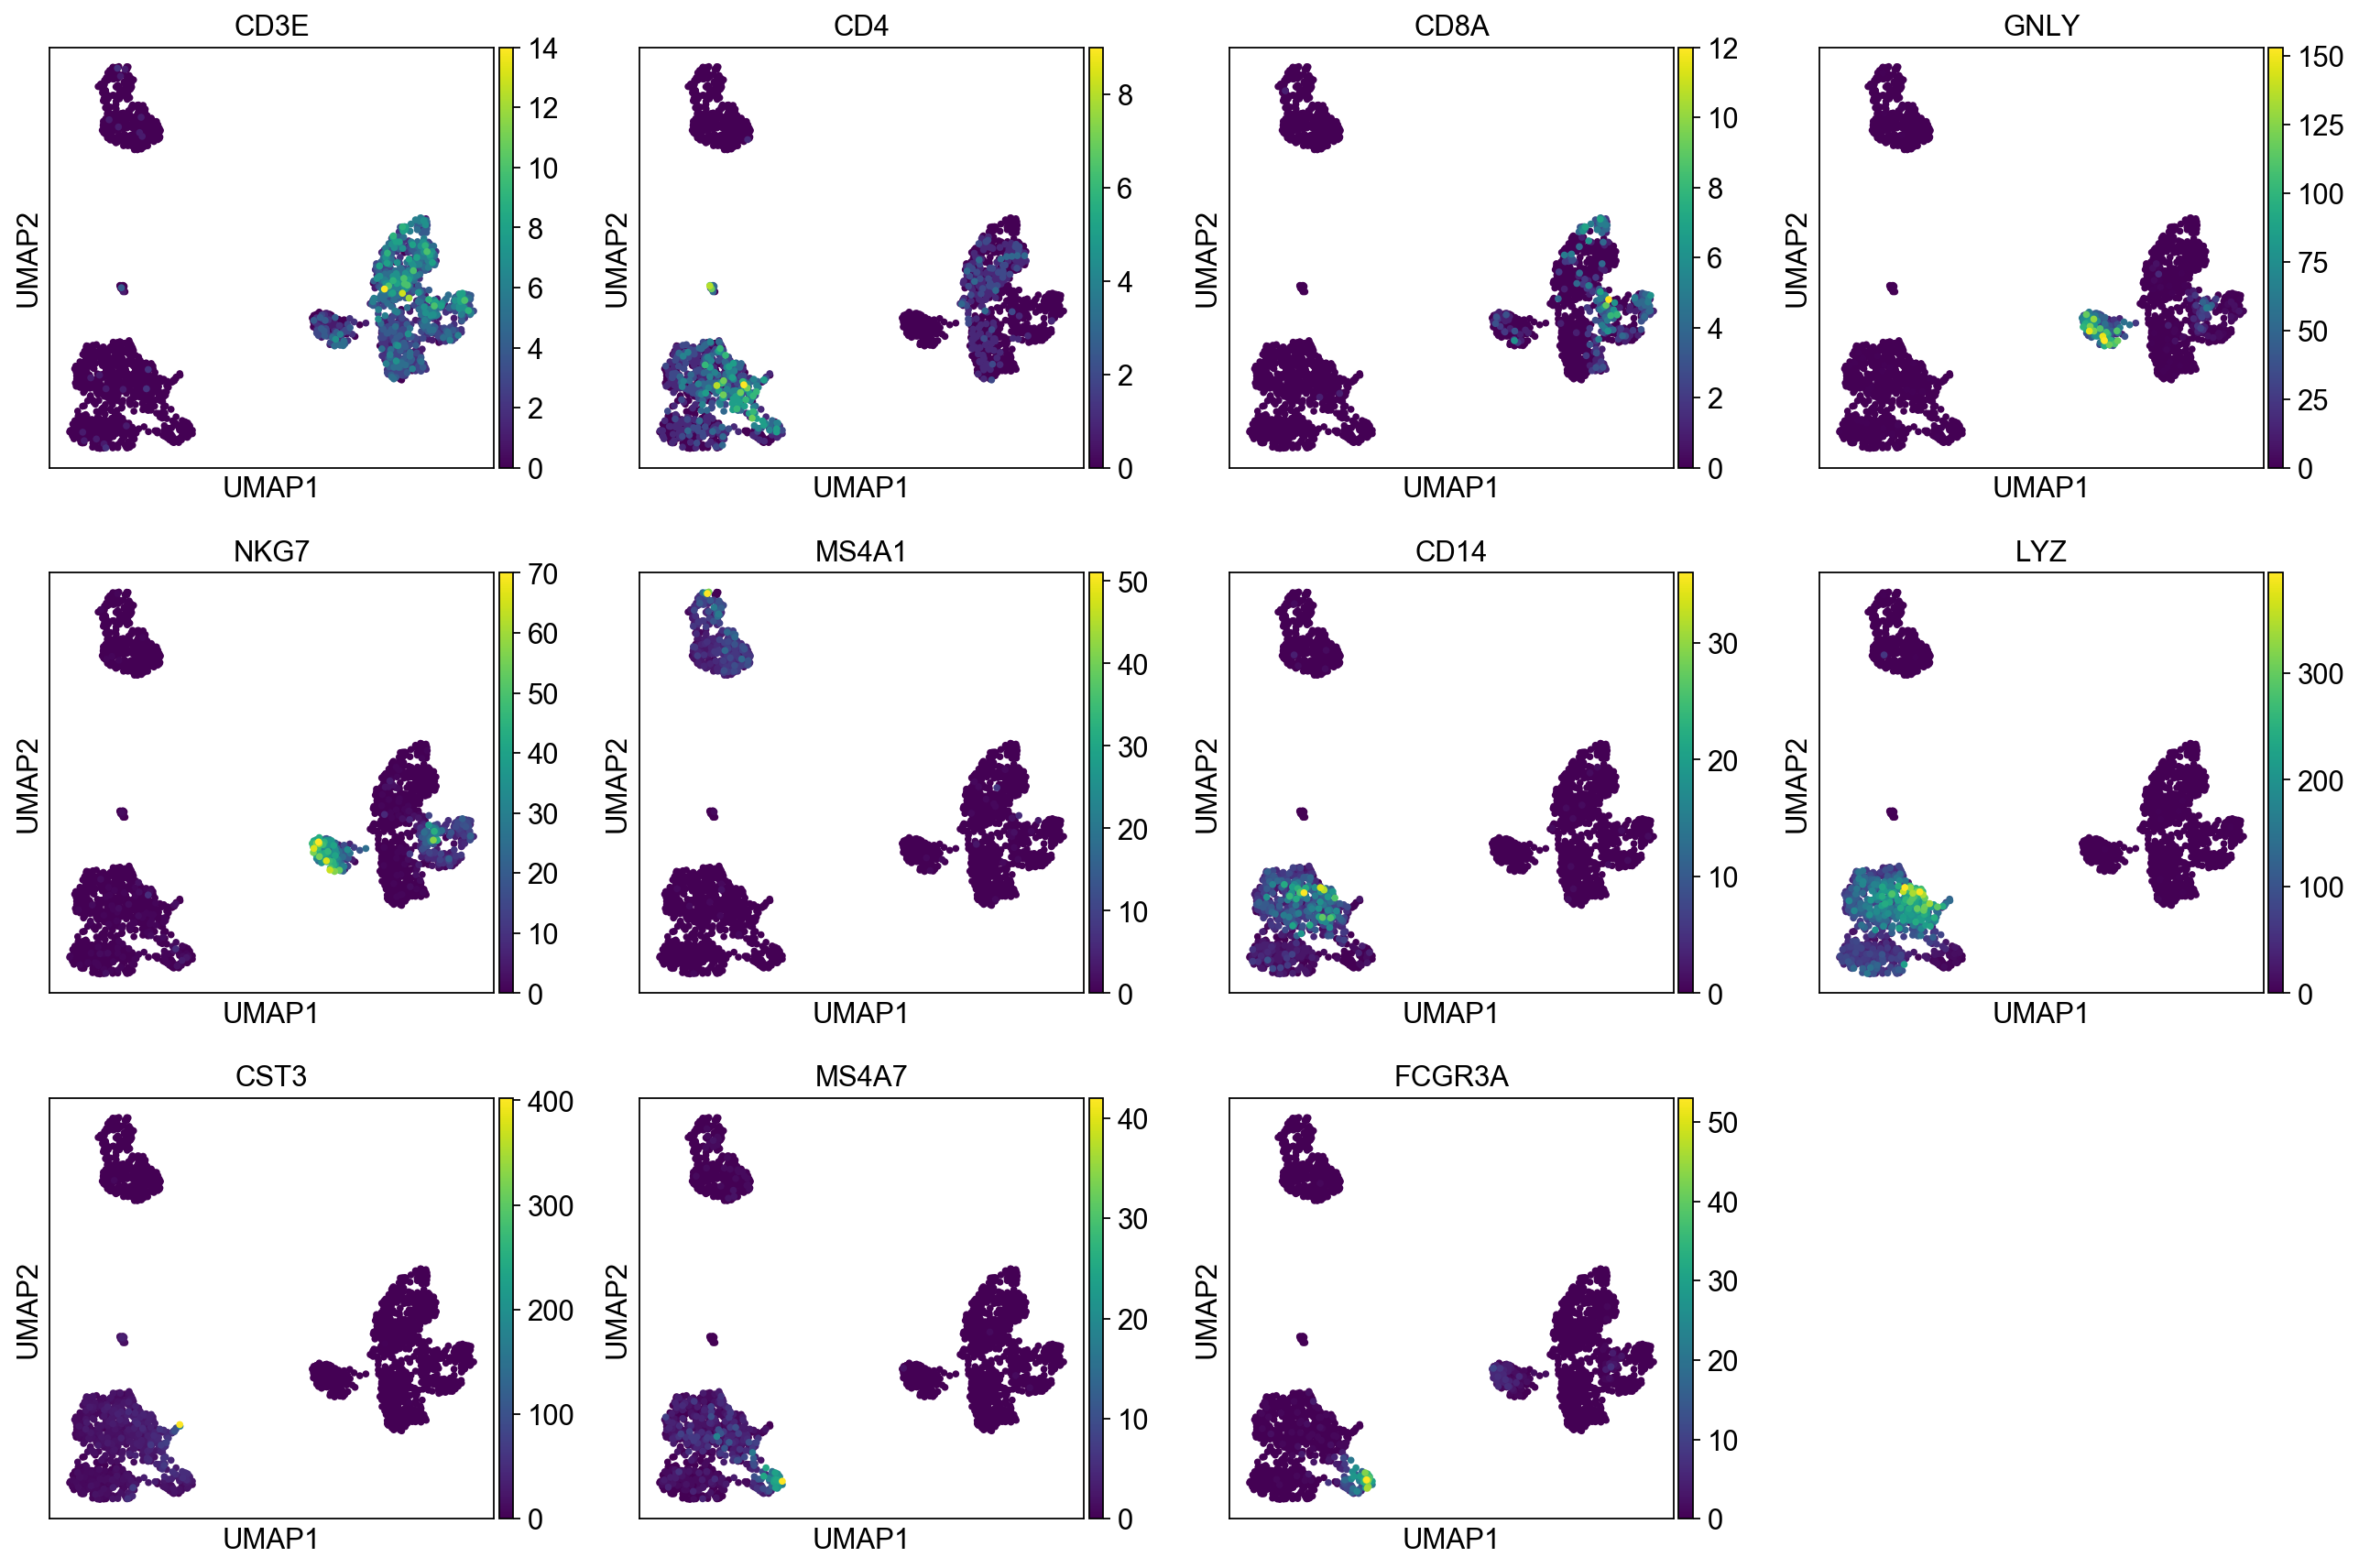

In [27]:
sc.pl.umap(adata, color=["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","CD14","LYZ","CST3","MS4A7","FCGR3A"])



 The default is to plot gene expression in the normalized and log-transformed data. You can also plot it on the scaled and corrected data by using `use_raw=False`. However, not all of these genes are included in the variable gene set so we first need to filter them. 


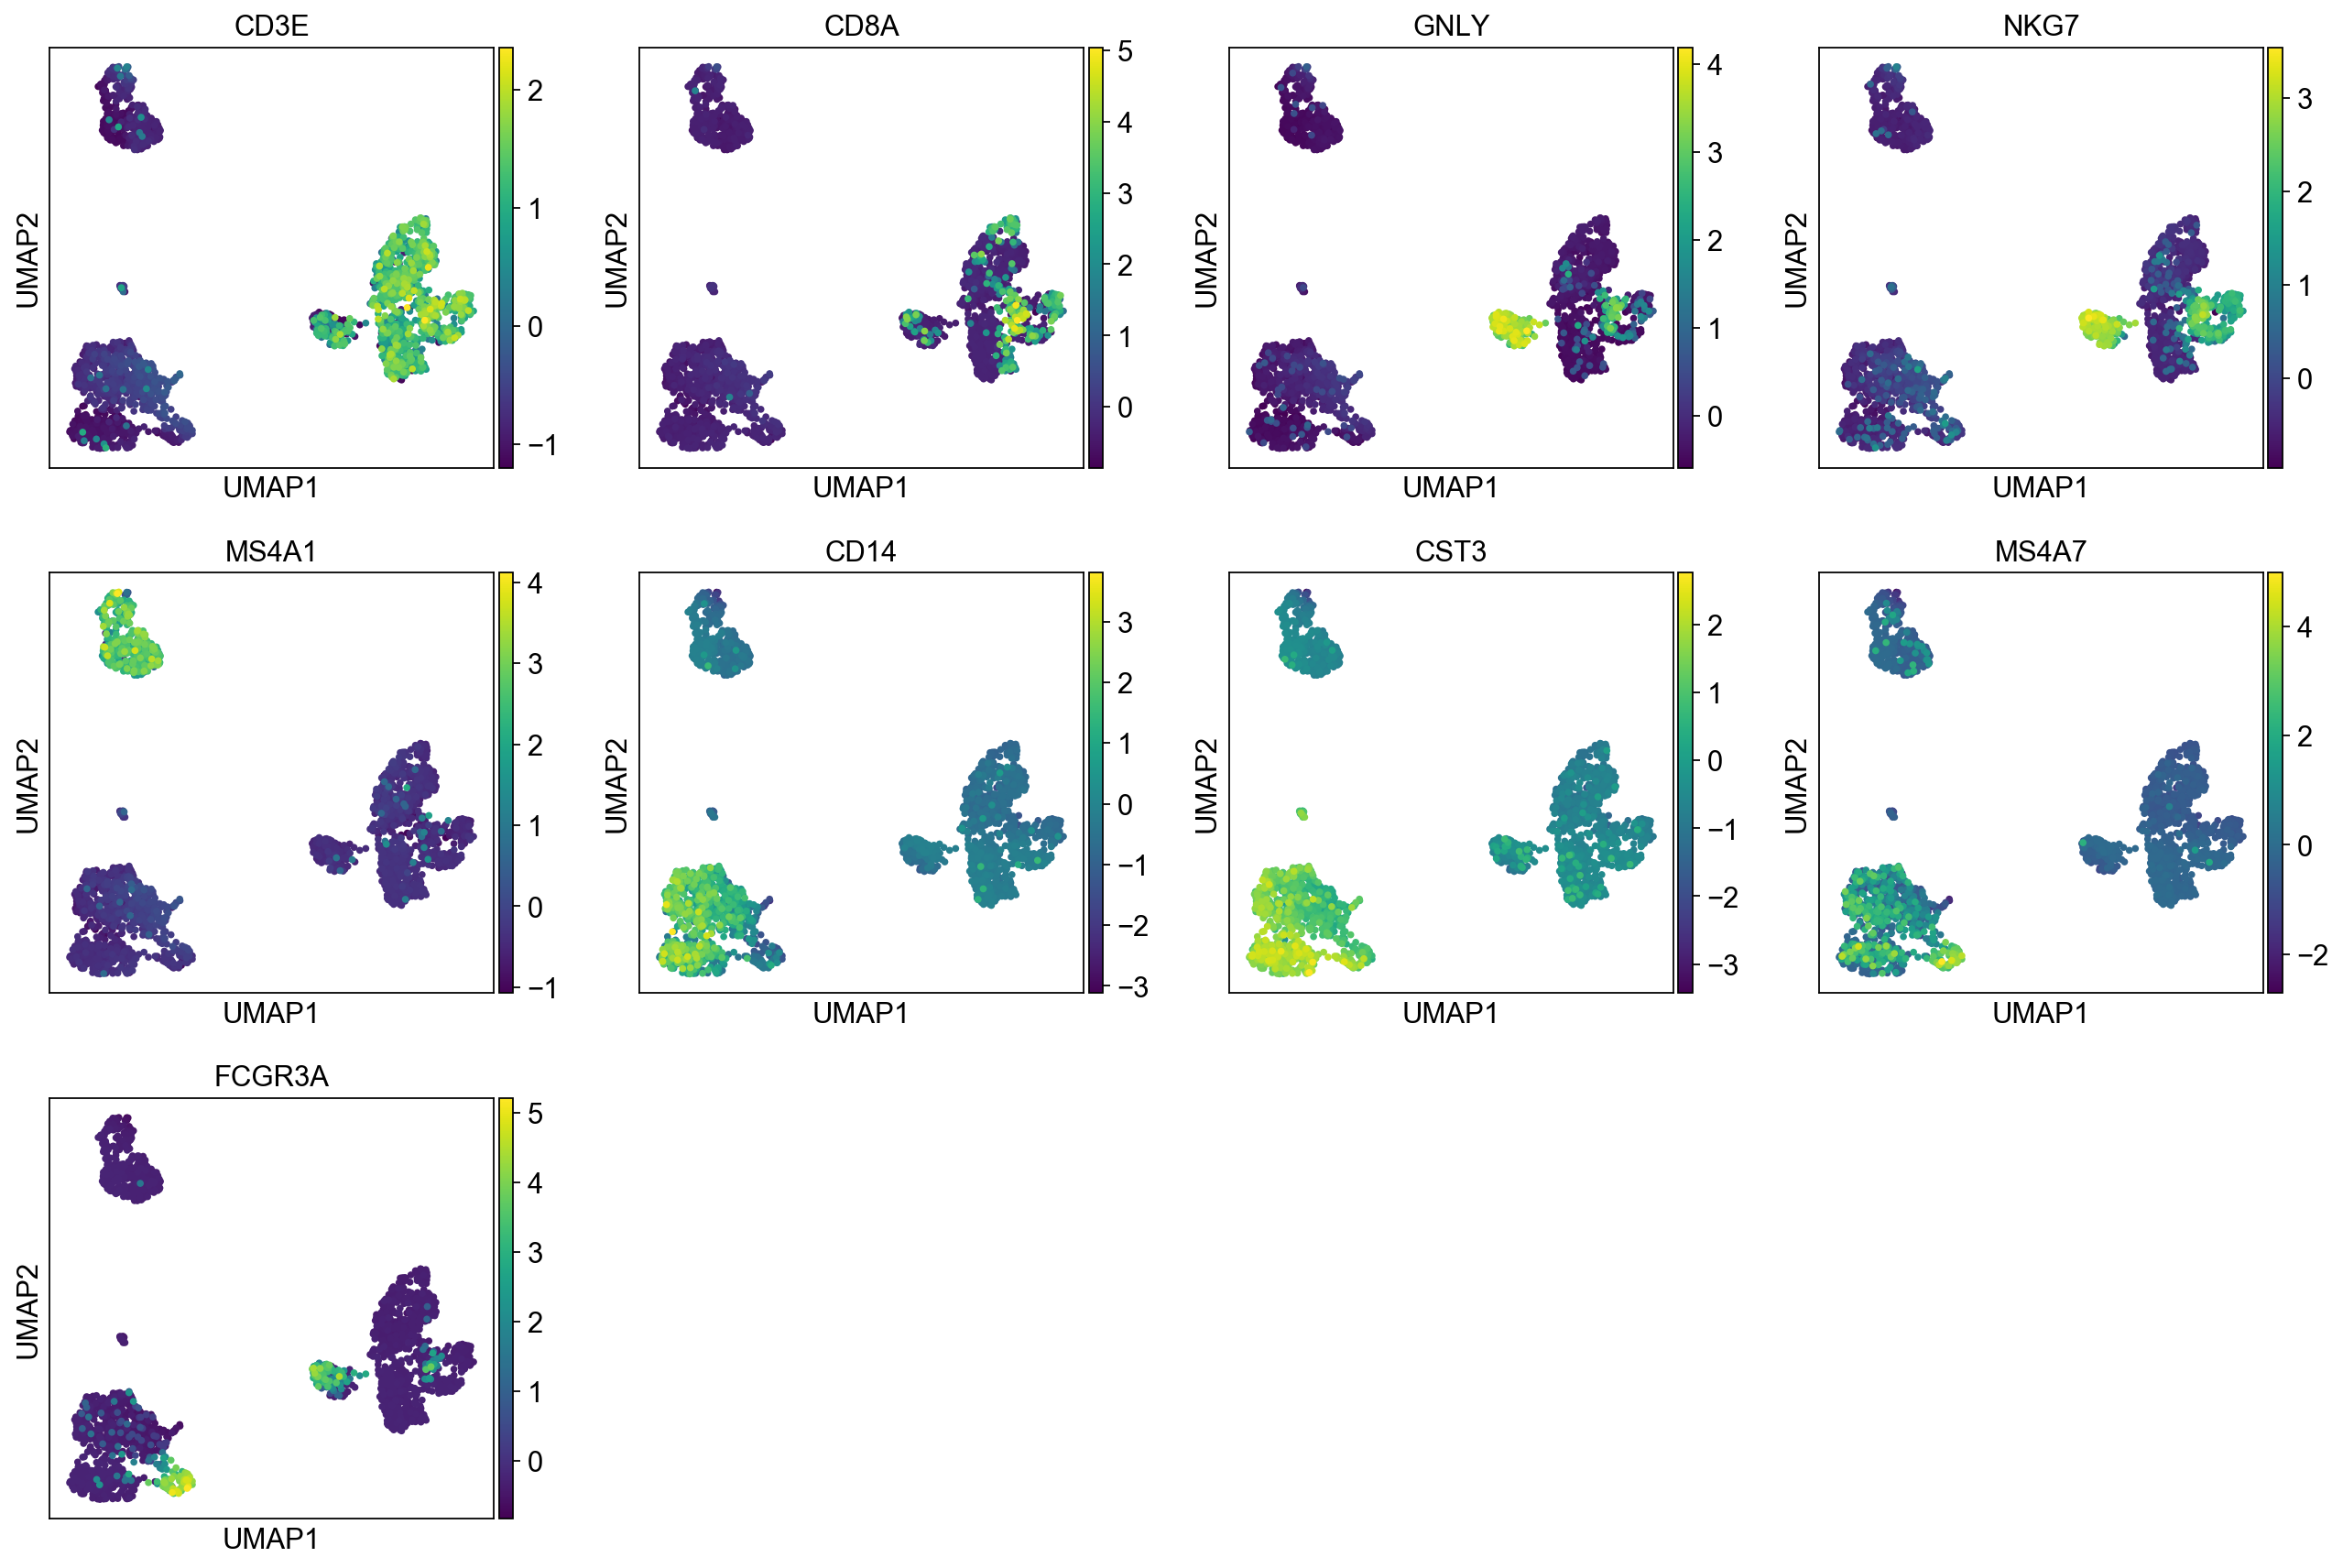

In [28]:
genes  = ["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","CD14","LYZ","CST3","MS4A7","FCGR3A"]
var_genes = adata.var.highly_variable
var_genes.index[var_genes]
varg = [x for x in genes if x in var_genes.index[var_genes]]
sc.pl.umap(adata, color=varg, use_raw=False)

We can finally save the object for use in future steps.


In [29]:
adata.write_h5ad('data/scanpy_dr_3pbmc.h5ad')

In [30]:
print(adata.X.shape)
print(adata.raw.X.shape)

(2527, 2472)
(2527, 16766)
